#**Install necessary libraries**

In [ ]:
!pip install tensorflow yfinance pandas numpy matplotlib seaborn scikit-learn


#**Import libraries**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math
import pickle


#**Fetch data**


In [ ]:
# List of tickers
tickers = ["GOOGL", "MSFT", "AAPL", "IBM"]

# Download the data for the specified period for all tickers
data = yf.download(tickers, start="2010-01-01", end="2023-01-01")

# Stack the data for all tickers into a single DataFrame
data = data.stack(level=1).reset_index(level=1)
data = data.rename_axis('Date').reset_index()

# Display the data
print(data.head())

[*********************100%%**********************]  4 of 4 completed

Price       Date Ticker  Adj Close       Close        High         Low  \
0     2010-01-04   AAPL   6.470740    7.643214    7.660714    7.585000   
1     2010-01-04  GOOGL  15.666453   15.684434   15.753504   15.621622   
2     2010-01-04    IBM  76.012856  126.625237  127.122368  125.095604   
3     2010-01-04   MSFT  23.389402   30.950001   31.100000   30.590000   
4     2010-01-05   AAPL   6.481929    7.656429    7.699643    7.616071   

Price        Open     Volume  
0        7.622500  493729600  
1       15.689439   78169752  
2      125.411087    6438444  
3       30.620001   38409100  
4        7.664286  601904800  


#**Convert categorical data using onehotencoding**

In [ ]:
# One-hot encode the 'Ticker' column
encoder = OneHotEncoder(sparse=False)
ticker_encoded = encoder.fit_transform(data[['Ticker']])

# Create a DataFrame for the one-hot encoded tickers
ticker_encoded_df = pd.DataFrame(ticker_encoded, columns=encoder.get_feature_names_out(['Ticker']))

# Concatenate the one-hot encoded tickers with the original data
data = pd.concat([data, ticker_encoded_df], axis=1)

# Drop the original 'Ticker' column as it's now encoded
data.drop(columns=['Ticker'], inplace=True)

# Display the combined DataFrame
print(data.head())

        Date  Adj Close       Close        High         Low        Open  \
0 2010-01-04   6.470740    7.643214    7.660714    7.585000    7.622500   
1 2010-01-04  15.666453   15.684434   15.753504   15.621622   15.689439   
2 2010-01-04  76.012856  126.625237  127.122368  125.095604  125.411087   
3 2010-01-04  23.389402   30.950001   31.100000   30.590000   30.620001   
4 2010-01-05   6.481929    7.656429    7.699643    7.616071    7.664286   

      Volume  Ticker_AAPL  Ticker_GOOGL  Ticker_IBM  Ticker_MSFT  
0  493729600          1.0           0.0         0.0          0.0  
1   78169752          0.0           1.0         0.0          0.0  
2    6438444          0.0           0.0         1.0          0.0  
3   38409100          0.0           0.0         0.0          1.0  
4  601904800          1.0           0.0         0.0          0.0  


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#**Check for missing values and drop if any**

In [ ]:
data.dropna(inplace=True)
data.reset_index(inplace=True)

#**Visualize the stock prices**

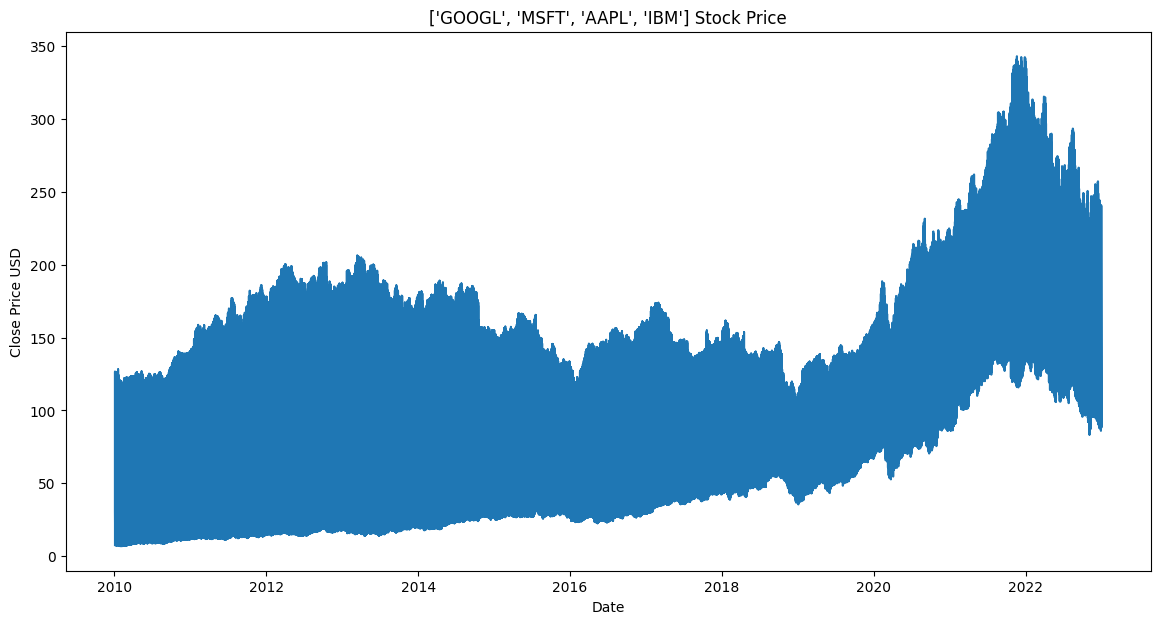

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Close'])
plt.title(f"{tickers} Stock Price")
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.show()


#**Feature Engineering**

In [ ]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek

#**Data Normalization**

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close']])

#**Create the dataset for LSTM**


In [ ]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X, y = create_dataset(scaled_data, time_step)

#**Reshape the input to be [samples, time steps, features] for LSTM**


In [ ]:
X = X.reshape(X.shape[0], X.shape[1], 1)


#**Split the data into training and testing sets**


In [ ]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

#**Build the LSTM model**


In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#**Compile the model**

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

#**Train the model**


In [ ]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

10389/10389 [==============================] - 557s 53ms/step - loss: 0.0021


#**Save and download the model**

In [ ]:
# Save the model
with open('stock_lstm_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Download the saved model file to your local machine
from google.colab import files
files.download("stock_lstm_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**Make predictions**


In [ ]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


82/82 [==============================] - 4s 34ms/step


#**Calculate evaluation metrics**


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def adjusted_r_squared(y_true, y_pred, n, p):
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
    return adjusted_r2

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adjusted_r2 = adjusted_r_squared(y_test, y_pred, len(y_test), X_test.shape[1])

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R-squared (R²): {r2}")
print(f"Adjusted R-squared: {adjusted_r2}")

Mean Absolute Error (MAE): 13.5844701351433
Mean Squared Error (MSE): 298.41159864273806
Root Mean Squared Error (RMSE): 17.274594022515785
Mean Absolute Percentage Error (MAPE): 9.71393317860095
R-squared (R²): 0.9261096484085299
Adjusted R-squared: 0.9231504833467971


#**Visualize the predictions**


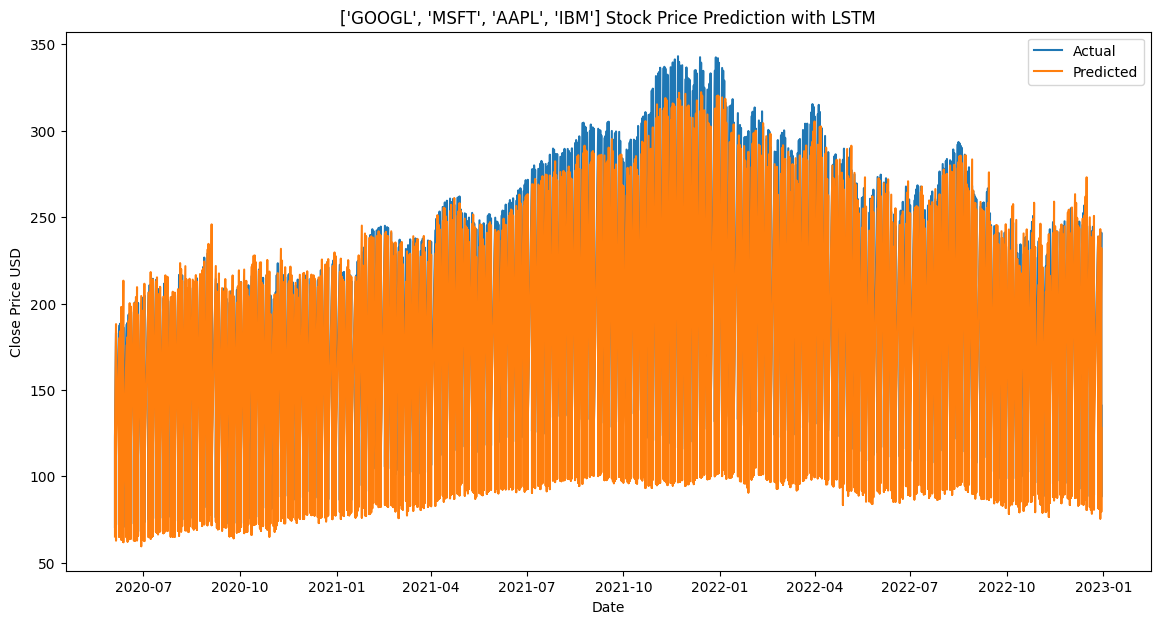

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(data['Date'][len(data)-len(y_test):], y_test, label='Actual')
plt.plot(data['Date'][len(data)-len(y_test):], y_pred, label='Predicted')
plt.title(f"{tickers} Stock Price Prediction with LSTM")
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.legend()
plt.show()